In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import statistics
import itertools

In [2]:
simplify_dir = '/Volumes/Data2/RST/notebook/GTFS/TTC_2016-10-03/GIS Simplify/'
gtfs_dir = '/Volumes/Data2/RST/notebook/GTFS/TTC_2016-10-03/'

In [3]:
# simplify_dir = 'D:/RST/RST/notebook/GTFS/TTC_2016-10-03/GIS Simplify/'

# gtfs_dir = 'D:/RST/notebook/GTFS/TTC_2016-10-03/'

In [4]:
ward_int = pd.read_csv('/Volumes/Data2/RST/notebook/GIS/int_wards.csv')

#ward_int = pd.read_csv('D:/RST/notebook/GIS/int_wards.csv')

ward_int['INT_ID_STR'] = ward_int['INT_ID'].astype(str)

In [5]:
period = 'EV'
period_hr = 20

In [6]:
# G = nx.read_gexf('D:/RST/notebook/networks/' + period +'-RM-16-singleDi.gexf')
# graph_data = pd.read_csv('D:/RST/notebook/networks/' + period +'-RM-16-singleDi.csv')


G = nx.read_gexf('/Volumes/Data2/RST/notebook/networks/' + period +'-RM-16-singleDi.gexf')
graph_data = pd.read_csv('/Volumes/Data2/RST/notebook/networks/' + period +'-RM-16-singleDi.csv')



stop_times_od = pd.read_csv(gtfs_dir + 'stop_times_full.csv')

In [7]:
route_dir = stop_times_od[stop_times_od['hr_o'] == period_hr]
route_dir = route_dir[['INT_ID_o', 'INT_ID_d', 'route_short_name']].drop_duplicates()
route_dir = route_dir.groupby(['INT_ID_o', 'INT_ID_d'])['route_short_name'].apply(list).reset_index()
route_dir = route_dir.merge(graph_data)

In [8]:
def func(row):

    single_cycle = row.copy()
    single_cycle.append(single_cycle[0])
    single_cycle.append(None)


    cycle_pairs = list(zip(single_cycle [::1], single_cycle [1::1]))[:-1]
    cycle_pairs = [list(map(int, sublist)) for sublist in cycle_pairs]
    cycle_df = route_dir.merge(pd.DataFrame.from_records(cycle_pairs, columns = ['INT_ID_o', 'INT_ID_d']))

    first_route = cycle_df.iloc[0,2]

    #check for cycles where it can be traversed by 1 route, ie eliminate out and back trips
    for route in first_route:
        if len(cycle_df[cycle_df['route_short_name'].apply(lambda x: route in x)]) == len(cycle_df):
            return ward,0,0,1
            break
        else:
            return ward, 1, cycle_df['scaled_freq'].min(), 0

In [9]:
result_list = []
ward_n = []

ward = 5



G_ward = G.copy()


G_ward.remove_nodes_from(list(ward_int[ward_int['AREA_SHORT_CODE'] != ward]['INT_ID_STR']))

N = G_ward.size()

#find cycles
cycle_list = list(nx.simple_cycles(G_ward))
print('Ward ' + str(ward) + ', Size ' + str(N) + ' Found '+ str(len(cycle_list)) + ' cycles')

temp_list = list(map(func, cycle_list))

result_list.append(temp_list)
ward_n.append([ward, N])


Ward 5, Size 359 Found 63341 cycles


In [17]:
len(cycle_list[0])

71

In [16]:
len(cycle_list[1])

62

In [18]:

single_cycle = cycle_list[0]
single_cycle.append(single_cycle[0])
single_cycle.append(None)


cycle_pairs = list(zip(single_cycle [::1], single_cycle [1::1]))[:-1]
cycle_pairs = [list(map(int, sublist)) for sublist in cycle_pairs]
cycle_df = route_dir.merge(pd.DataFrame.from_records(cycle_pairs, columns = ['INT_ID_o', 'INT_ID_d']))

first_route = cycle_df.iloc[0,2]

In [20]:
df_list = []
j = 0
for i in cycle_list:
    df_list.append([j, len(i)])
    j = j + 1

In [22]:
len_df = pd.DataFrame.from_records(df_list, columns = ['num', 'len'])

In [27]:
len_df.groupby('len').count().sort_values(by = 'num', ascending = False)

,num
len,
66,1886
64,1881
63,1879
67,1869
61,1857
...,...
7,2
6,2
10,2


<AxesSubplot:>

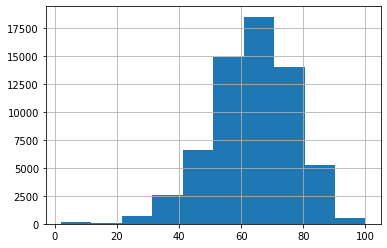

In [34]:
len_df['len'].hist()

In [35]:
len_df[len_df['len'] == 66]

,num,len
100,100,66
106,106,66
109,109,66
115,115,66
120,120,66
...,...,...
62690,62690,66
62764,62764,66
62867,62867,66
62870,62870,66


In [47]:
from collections import Counter
unique_count = (Counter(map(tuple, cycle_list)))

In [49]:
df = pd.DataFrame.from_dict(unique_count, orient='index').reset_index()

In [44]:
test = list(nx.minimum_cycle_basis(G_ward))

NetworkXNotImplemented: not implemented for directed type